# import libraries

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    make_scorer,
    f1_score,
    recall_score
)

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# load Data

In [2]:
notebook_dir = os.getcwd()   

notebooks_folder = os.path.dirname(notebook_dir)

project_root = os.path.dirname(notebooks_folder)

data_path = os.path.join(project_root, "Data", "FinalData.csv")

df = pd.read_csv(data_path)

df.head()


,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,is_long_term
0,0,Yes,No,1,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,0
1,0,No,No,34,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,1
2,0,No,No,2,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0
3,0,No,No,45,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1
4,0,No,No,2,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


In [3]:
df['Churn'] = df['Churn'].replace({"Yes": 1, "No": 0})

/tmp/ipykernel_790/196801821.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({"Yes": 1, "No": 0})


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7043 non-null   int64  
 1   Partner           7043 non-null   object 
 2   Dependents        7043 non-null   object 
 3   tenure            7043 non-null   int64  
 4   InternetService   7043 non-null   object 
 5   OnlineSecurity    7043 non-null   object 
 6   OnlineBackup      7043 non-null   object 
 7   DeviceProtection  7043 non-null   object 
 8   TechSupport       7043 non-null   object 
 9   StreamingTV       7043 non-null   object 
 10  StreamingMovies   7043 non-null   object 
 11  Contract          7043 non-null   object 
 12  PaperlessBilling  7043 non-null   object 
 13  PaymentMethod     7043 non-null   object 
 14  MonthlyCharges    7043 non-null   float64
 15  TotalCharges      7043 non-null   float64
 16  Churn             7043 non-null   int64  


In [7]:
df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [8]:
X = df.drop(columns = ['Churn'])
y = df['Churn']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
y_train.value_counts()

Churn
0    4138
1    1496
Name: count, dtype: int64

# Model Tuning and Selection

In [11]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

}

In [12]:

hyperparameters = {
    "Random Forest": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [5, 10, None],
        "classifier__min_samples_split": [2, 5],
        "classifier__min_samples_leaf": [1, 2],
        "classifier__max_features": ["sqrt", "log2"]
    },

    "XGBoost": {
        "classifier__n_estimators": [100, 200],
        "classifier__max_depth": [3, 5, 7],
        "classifier__learning_rate": [0.01, 0.1, 0.2],
        "classifier__subsample": [0.7, 1],
        "classifier__colsample_bytree": [0.7, 1]
    }
}



In [ ]:
multi_cat_columns = [
    'Partner',
    'Dependents',
    'PaperlessBilling',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'Contract',
    'PaymentMethod'
]

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}

for model_name, model in models.items():
    print(f"Tuning {model_name}...")

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), multi_cat_columns)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)  
    ])

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=hyperparameters[model_name],
        cv=cv,
        scoring="f1",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)  

    best_models[model_name] = grid.best_estimator_

    print(f"Best parameters for {model_name}: {grid.best_params_}")
    print(f"Best F1 score for {model_name}: {grid.best_score_:.4f}\n")

Tuning Random Forest...


Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best F1 score for Random Forest: 0.6273

Tuning XGBoost...


/home/alialdin/Customer-Churn-Prediction-and-Analysis_DEPI_3/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:41:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alialdin/Customer-Churn-Prediction-and-Analysis_DEPI_3/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:41:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alialdin/Customer-Churn-Prediction-and-Analysis_DEPI_3/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:41:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/alialdin/Customer-Churn-Prediction-and-Analysis_DEPI_3/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:41:21] WARNING: /wo

Best parameters for XGBoost: {'classifier__colsample_bytree': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 1}
Best F1 score for XGBoost: 0.6303



/home/alialdin/Customer-Churn-Prediction-and-Analysis_DEPI_3/.venv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [11:41:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Class Distribution Before and After SMOTE

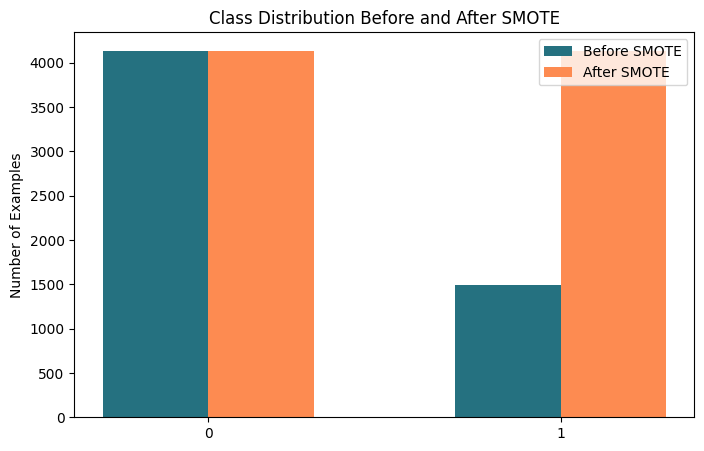

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import pandas as pd

X_num = X_train[numerical_cols]
X_cat = X_train[multi_cat_columns]

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_enc = pd.DataFrame(ohe.fit_transform(X_cat), columns=ohe.get_feature_names_out(multi_cat_columns))

X_encoded = pd.concat([X_num.reset_index(drop=True), X_cat_enc.reset_index(drop=True)], axis=1)

before_smote = Counter(y_train)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_encoded, y_train)
after_smote = Counter(y_res)

classes = list(before_smote.keys())
before_counts = [before_smote[c] for c in classes]
after_counts = [after_smote[c] for c in classes]

x = range(len(classes))

plt.figure(figsize=(8,5))
plt.bar([i-0.15 for i in x], before_counts, width=0.3, label='Before SMOTE', color='#257180')
plt.bar([i+0.15 for i in x], after_counts, width=0.3, label='After SMOTE', color='#FD8B51')
plt.xticks(x, classes)
plt.ylabel("Number of Examples")
plt.title("Class Distribution Before and After SMOTE")
plt.legend()
plt.show()


In [15]:
best_models

{'Random Forest': Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['tenure', 'MonthlyCharges',
                                                    'TotalCharges']),
                                                  ('cat',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['Partner', 'Dependents',
                                                    'PaperlessBilling',
                                                    'InternetService',
                                                    'OnlineSecurity',
                                                    'OnlineBackup',
                                                    'DeviceProtection',
                                                    'TechSupport', 'StreamingTV',
                                                    'Streaming

# Save Random Forest Model

In [16]:


notebook_dir = os.getcwd()

notebooks_folder = os.path.dirname(notebook_dir)

project_root = os.path.dirname(notebooks_folder)

models_path = os.path.join(project_root, "models")

os.makedirs(models_path, exist_ok=True)

Random_Forest_path = os.path.join(models_path, "Random_Forest.pkl")

with open(Random_Forest_path, "wb") as f:
    pickle.dump(best_models['Random Forest'], f)

print(f"best_model saved at: {Random_Forest_path}")


best_model saved at: /home/alialdin/Customer-Churn-Prediction-and-Analysis_DEPI_3/models/Random_Forest.pkl


# Save Random XGBoost

In [17]:


notebook_dir = os.getcwd()

notebooks_folder = os.path.dirname(notebook_dir)

project_root = os.path.dirname(notebooks_folder)

models_path = os.path.join(project_root, "models")

os.makedirs(models_path, exist_ok=True)

XGBoost_path = os.path.join(models_path, "XGBoost.pkl")

# حفظ الملف
with open(XGBoost_path, "wb") as f:
    pickle.dump(best_models['XGBoost'], f)

print(f"best_model saved at: {XGBoost_path}")


best_model saved at: /home/alialdin/Customer-Churn-Prediction-and-Analysis_DEPI_3/models/XGBoost.pkl


# models summary

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

for model_name, model_pipeline in best_models.items():
    print(f"Testing {model_name} on test data...\n")
    
    y_pred = model_pipeline.predict(X_test)
    
    try:
        y_proba = model_pipeline.predict_proba(X_test)[:, 1]
    except:
        y_proba = None
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    print("-----------------------------------------------------\n")


Testing Random Forest on test data...

Accuracy: 0.7786
F1 Score: 0.6381
ROC-AUC Score: 0.8563

Confusion Matrix:
[[822 214]
 [ 98 275]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1036
           1       0.56      0.74      0.64       373

    accuracy                           0.78      1409
   macro avg       0.73      0.77      0.74      1409
weighted avg       0.81      0.78      0.79      1409

-----------------------------------------------------

Testing XGBoost on test data...

Accuracy: 0.7892
F1 Score: 0.6566
ROC-AUC Score: 0.8610

Confusion Matrix:
[[828 208]
 [ 89 284]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1036
           1       0.58      0.76      0.66       373

    accuracy                           0.79      1409
   macro avg       0.74      0.78      0.75      1409
weighted avg       0.82      0

# XGBoost

In [19]:
y_test_pred = best_models['XGBoost'].predict(X_test)
y_test_prob = best_models['XGBoost'].predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred

array([1, 0, 0, ..., 0, 0, 1], shape=(1409,))

In [ ]:
y_test_prob

array([0.8560318 , 0.21832359, 0.02012035, ..., 0.06597522, 0.0468554 ,
       0.66379184], shape=(1409,), dtype=float32)

# performance

In [22]:
print(f"Accuracy : ", accuracy_score(y_test, y_test_pred))
print(f"ROC - AUC Score : ", roc_auc_score(y_test, y_test_prob))
print(f"Confusion Matrix : \n", confusion_matrix(y_test, y_test_pred))

print(f"Classification Report : \n", classification_report(y_test, y_test_pred))
print("F1 Score LogisticRegression:", f1_score(y_test, y_test_pred))


Accuracy :  0.7892122072391767
ROC - AUC Score :  0.8610142122206464
Confusion Matrix : 
 [[828 208]
 [ 89 284]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.90      0.80      0.85      1036
           1       0.58      0.76      0.66       373

    accuracy                           0.79      1409
   macro avg       0.74      0.78      0.75      1409
weighted avg       0.82      0.79      0.80      1409

F1 Score LogisticRegression: 0.6566473988439306


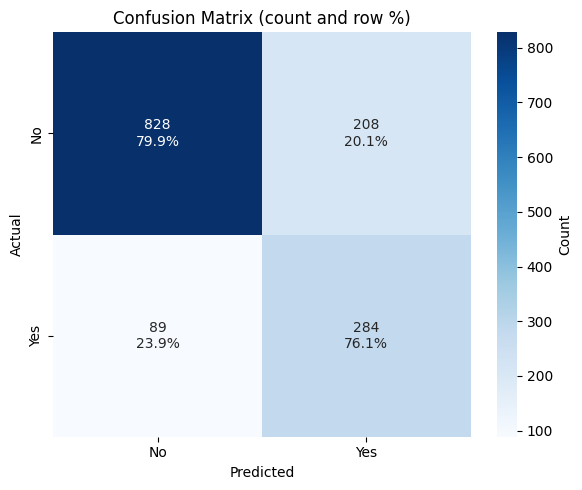

In [55]:
cm = confusion_matrix(y_test, y_test_pred)
labels = ['No', 'Yes']

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percent = cm_norm * 100
annot = np.empty_like(cm).astype(object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i, j]}\n{cm_percent[i, j]:.1f}%"

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (count and row %)')
plt.tight_layout()
plt.gcf().patch.set_alpha(0.0)
plt.gca().set_facecolor('none')
plt.show()

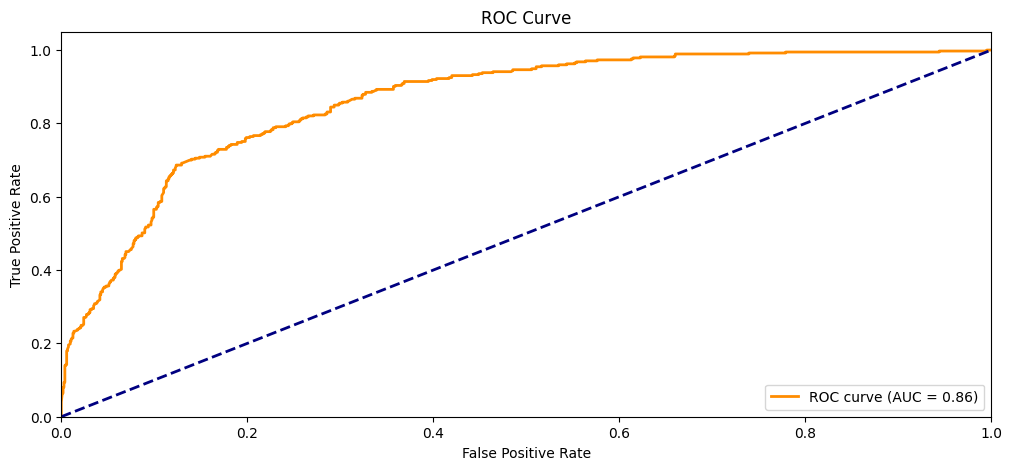

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,5))

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")




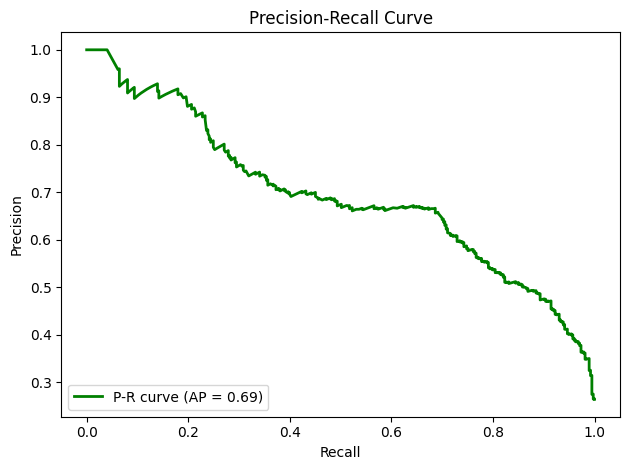

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
avg_precision = average_precision_score(y_test, y_test_prob)

plt.plot(recall, precision, color='green', lw=2, label=f'P-R curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Random_Forest

In [25]:
y_test_pred2 = best_models['Random Forest'].predict(X_test)
y_test_prob2 = best_models['Random Forest'].predict_proba(X_test)[:, 1]

In [ ]:
y_test_pred2

array([1, 0, 0, ..., 0, 0, 1], shape=(1409,))

In [ ]:
y_test_prob2

array([0.85984515, 0.175154  , 0.01762598, ..., 0.03536367, 0.03595879,
       0.50579954], shape=(1409,))

# performance

In [1]:
print(f"Accuracy : ", accuracy_score(y_test, y_test_pred2))
print(f"ROC - AUC Score : ", roc_auc_score(y_test, y_test_prob2))
print(f"Confusion Matrix : \n", confusion_matrix(y_test, y_test_pred2))

print(f"Classification Report : \n", classification_report(y_test, y_test_pred2))
print("F1 Score LogisticRegression:", f1_score(y_test, y_test_pred2))


NameError: name 'accuracy_score' is not defined

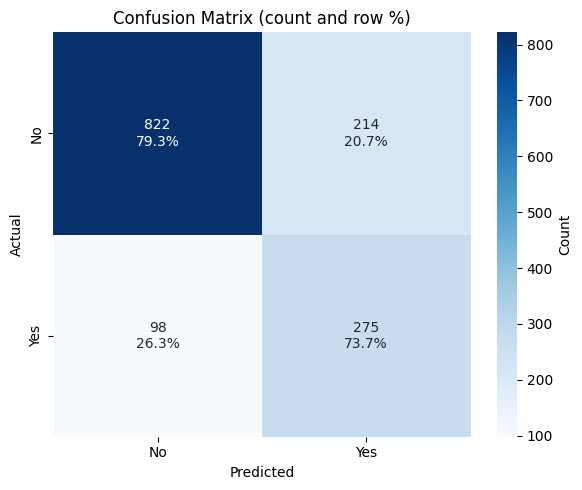

In [ ]:
cm = confusion_matrix(y_test, y_test_pred2)
labels = ['No', 'Yes']

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_percent = cm_norm * 100
annot = np.empty_like(cm).astype(object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i, j]}\n{cm_percent[i, j]:.1f}%"

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (count and row %)')
plt.tight_layout()
plt.gcf().patch.set_alpha(0.0)
plt.gca().set_facecolor('none')
plt.show()

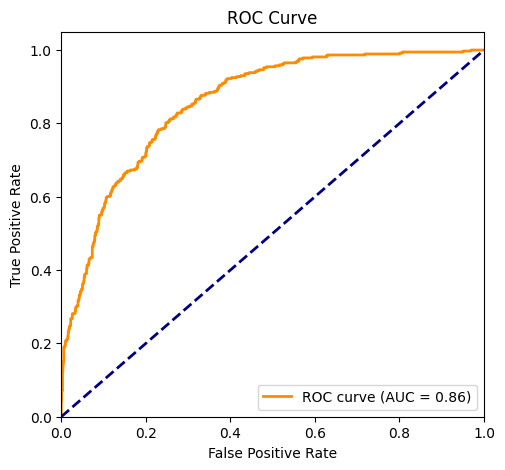

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

fpr2, tpr2, thresholds = roc_curve(y_test, y_test_prob2)
roc_auc2 = auc(fpr2, tpr2)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc2:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.gca().set_facecolor('none')




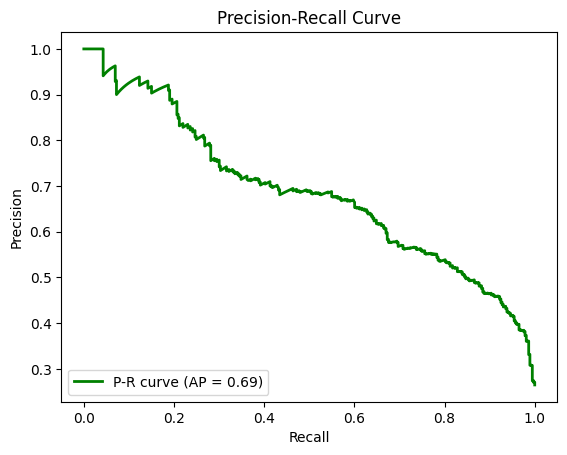

In [ ]:
precision2, recall2, _ = precision_recall_curve(y_test, y_test_prob2)
avg_precision2 = average_precision_score(y_test, y_test_prob2)


plt.plot(recall2, precision2, color='green', lw=2, label=f'P-R curve (AP = {avg_precision2:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")


plt.show()

# Test Prediction

In [ ]:
notebook_dir = os.getcwd()
notebooks_folder = os.path.dirname(notebook_dir)
project_root = os.path.dirname(notebooks_folder)
models_path = os.path.join(project_root, "models")

XGBoost_path = os.path.join(models_path, "XGBoost.pkl")
with open(XGBoost_path, "rb") as f:
    loaded_model = pickle.load(f)

def make_prediction(input_data: dict):
    """
    input_data: dictionary with same features used in training pipeline
    returns: tuple (prediction_label, probability_of_churn)
    """
    input_df = pd.DataFrame([input_data])
    
    prediction = loaded_model.predict(input_df)[0]
    probability = loaded_model.predict_proba(input_df)[0, 1] 
    
    return "Churn" if prediction == 1 else "No Churn", probability

example_input_Churn = {
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 50,
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Credit card (automatic)',
    'MonthlyCharges': 1000.85,
    'TotalCharges': 290.85,
    'is_long_term': 1
}

prediction_label, probability = make_prediction(example_input_Churn)
print(f"Prediction: {prediction_label}, Probability of Churn: {probability:.2f}")


Prediction: No Churn, Probability of Churn: 0.32


# --------------------------------------------------------------------------